## 필요 라이브러리 및 한글 출력 준비

In [1]:
# 기본 라이브러리
import polars as pl
import pandas as pd 
import seaborn as sns
import numpy as np

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, RobustScaler

import time

#  경고 메시지 무시
import warnings
warnings.filterwarnings("ignore")

# 한글 폰트 설정 (Matplotlib에서 한글 깨짐 방지)
import matplotlib.pyplot as plt

plt.rc("font", family="NanumGothic")  # Windows 사용자의 경우

# 마이너스 기호 깨짐 방지
plt.rcParams["axes.unicode_minus"] = False

# 시각화용 색상 팔레트
color_palette = sns.color_palette("Set2", as_cmap=False)
color='mediumaquamarine'

# 데이터 전처리
- 모든 코드는 iM뱅크 측에서 제공된 데이터를 전처리 할 때 사용된다는 것을 가정함
- 데이터 전처리 함수 생성 및 적용, 단, 제공된 학습기기의 하드웨어 문제 및 시연 시간을 고려하여 실제 실행 코드는 주석으로 처리 

In [2]:
# 보유상품수 추가 함수
def add_product_count(df: pl.DataFrame) -> pl.DataFrame:
    """
    '수신_요구불예금', '수신_거치식예금', '수신_적립식예금', '수신_펀드',
    '수신_외화예금', '대출금액', '카드_승인금액' 컬럼 값을 바탕으로 
    '보유상품수' 컬럼을 추가한다.
    
    각 컬럼 값이 0이 아니면 해당 상품을 보유했다고 간주한다.
    """
    
    # (컬럼 != 0) AND is_not_null() -> 보유 여부 계산
    df = df.with_columns([
        (pl.col("수신_요구불예금").is_not_null() & (pl.col("수신_요구불예금") != 0))
            .cast(pl.Int64).alias("수신_요구불예금_보유"),
        (pl.col("수신_거치식예금").is_not_null() & (pl.col("수신_거치식예금") != 0))
            .cast(pl.Int64).alias("수신_거치식예금_보유"),
        (pl.col("수신_적립식예금").is_not_null() & (pl.col("수신_적립식예금") != 0))
            .cast(pl.Int64).alias("수신_적립식예금_보유"),
        (pl.col("수신_펀드").is_not_null() & (pl.col("수신_펀드") != 0))
            .cast(pl.Int64).alias("수신_펀드_보유"),
        (pl.col("수신_외화예금").is_not_null() & (pl.col("수신_외화예금") != 0))
            .cast(pl.Int64).alias("수신_외화예금_보유"),
        (pl.col("대출금액").is_not_null() & (pl.col("대출금액") != 0))
            .cast(pl.Int64).alias("대출금액_보유"),
        (pl.col("카드_승인금액").is_not_null() & (pl.col("카드_승인금액") != 0))
            .cast(pl.Int64).alias("카드_승인금액_보유"),
    ])

    # 보유상품수 계산 (각 "_보유" 컬럼 합산)
    df = df.with_columns(
        (
            pl.col("수신_요구불예금_보유") + 
            pl.col("수신_거치식예금_보유") + 
            pl.col("수신_적립식예금_보유") + 
            pl.col("수신_펀드_보유") + 
            pl.col("수신_외화예금_보유") + 
            pl.col("대출금액_보유") + 
            pl.col("카드_승인금액_보유")
        ).alias("보유상품수")
    )

    # 임시 보유 여부 컬럼들 제거
    df = df.drop([
        "수신_요구불예금_보유", "수신_거치식예금_보유", "수신_적립식예금_보유",
        "수신_펀드_보유", "수신_외화예금_보유", "대출금액_보유", "카드_승인금액_보유"
    ])

    return df


# 데이터 전처리 함수
def preprocess_customer(df: pl.DataFrame) -> pl.DataFrame:
    """
    CUSTOMER 데이터프레임을 전처리하는 함수.
    1. 불필요 컬럼 삭제
    2. 특정 컬럼명 변경
    3. '입출금예금', '기타예금' 컬럼 생성 및 기존 컬럼 삭제
    4. '연령대' 컬럼 값 매핑 후 int 형 변환
    5. 컬럼 순서 정리

    Args:
        df (pl.DataFrame): 원본 CUSTOMER 데이터프레임
    
    Returns:
        pl.DataFrame: 전처리 완료된 CUSTOMER 데이터프레임
    """

    # 1. 불필요한 컬럼 삭제
    df = df.drop(['자택_시도', '자택_시군구', '카드_사용횟수', '카드_사용여부'])
    
    # 2. 컬럼명 변경
    df = df.rename({
        "수신_펀드": "비이자상품",
        "대출금액": "대출",
        "카드_승인금액": "카드"
    })
    
    # 3. '입출금예금', '기타예금' 컬럼 생성 후 기존 컬럼 삭제
    df = (
        df.with_columns(
            (pl.col('수신_요구불예금') + pl.col('수신_외화예금')).alias('입출금예금')
        )
        .drop(['수신_요구불예금', '수신_외화예금'])
        .with_columns(
            (pl.col('수신_거치식예금') + pl.col('수신_적립식예금')).alias('기타예금')
        )
        .drop(['수신_거치식예금', '수신_적립식예금'])
    )
    
    # 4. '연령대' 컬럼 변환 (매핑 후 int32로 변환)
    age_mapping = {"10대미만": 10, "20대": 20, "30대": 30, "40대": 40, "50대": 50, "60대이상": 60}
    df = df.with_columns(
        df['연령대']
        .replace(age_mapping)
        .cast(pl.Int32)
        .alias('연령대')
    )
    
    # 5. 컬럼 순서 정리
    #    - 새로 만든 컬럼들("입출금예금", "기타예금", "비이자상품", "카드", "대출", "보유상품수")을 맨 뒤로
    main_cols = ["입출금예금", "기타예금", "비이자상품", "카드", "대출", "보유상품수"]
    desired_order = [col for col in df.columns if col not in main_cols] + main_cols
    df = df.select(desired_order)

    return df


# 고객 점수 환산 함수
def calculate_financial_scores(df):
    """
    금융 데이터에 대해 3개월 평균, 3개월 누적, 6개월 평균 등을 기반으로 점수를 계산하는 함수.
    특히 '대출' 컬럼은 다음과 같은 로직으로 계산함:
      - 각 달의 기여액 = 대출금액 * (10 + 기준금리) / 100
      - 6개월 동안의 기여액 평균을 구한 뒤, 이를 25/10000로 곱해서 점수를 산출

    Args:
        df (pl.DataFrame): 고객 금융 데이터.
    
    Returns:
        pl.DataFrame: 계산된 금융 점수가 추가된 데이터프레임.
    """

    # 단위 점수 기준 (대출은 별도 로직이므로 제거/무시) - 출처 : iM뱅크 
    unit_scores = {
        "입출금예금": 8 / 100000,
        "기타예금": 4 / 100000,
        "비이자상품": 6 / 100000,
        "카드": 6 / 100000,
        "대출": 25 / 10000
    }

    # (1) 대출 기여액 컬럼 생성: 각 달의 대출금액 × (10 + 기준금리) / 100
    df = df.with_columns(
        (pl.col("대출") * (10 + pl.col("기준금리")) / 100).alias("대출_기여액")
    )

    # (2) 고객ID별 rolling 연산: 입출금예금, 기타예금, 비이자상품은 3개월 평균
    #    카드 사용액은 3개월 누적
    df = df.with_columns([
        (pl.col("입출금예금").rolling_sum(window_size=3, min_periods=1).over("고객ID") / 3).alias("입출금예금_3개월평균"),
        (pl.col("기타예금").rolling_sum(window_size=3, min_periods=1).over("고객ID") / 3).alias("기타예금_3개월평균"),
        (pl.col("비이자상품").rolling_sum(window_size=3, min_periods=1).over("고객ID") / 3).alias("비이자상품_3개월평균"),
        (pl.col("카드").rolling_sum(window_size=3, min_periods=1).over("고객ID")).alias("카드_3개월누적"),
        (pl.col("대출_기여액").rolling_sum(window_size=6, min_periods=1).over("고객ID") / 6).alias("대출_6개월평균_기여액")
    ])


    # (3) 점수 계산
    df = df.with_columns([
        (pl.col("입출금예금_3개월평균") * unit_scores["입출금예금"]).alias("입출금예금_점수"),
        (pl.col("기타예금_3개월평균") * unit_scores["기타예금"]).alias("기타예금_점수"),
        (pl.col("비이자상품_3개월평균") * unit_scores["비이자상품"]).alias("비이자상품_점수"),
        (pl.col("카드_3개월누적") * unit_scores["카드"]).alias("카드_점수"),
        (pl.col("대출_6개월평균_기여액") * unit_scores["대출"]).alias("대출_점수")
    ])

    # (5) 보유상품수에 따른 점수(상품_점수)
    df = df.with_columns(
        pl.when(pl.col("보유상품수") <= 4)
          .then(pl.col("보유상품수") * 10)
          .otherwise(40 + (pl.col("보유상품수") - 4) * 20)
          .alias("상품_점수")
    )

    # (6) 총점수 = 각 상품 점수 + 상품_점수
    df = df.with_columns(
        (pl.col("입출금예금_점수") +
         pl.col("기타예금_점수") +
         pl.col("비이자상품_점수") +
         pl.col("카드_점수") +
         pl.col("대출_점수") +
         pl.col("상품_점수")
        ).alias("총점수")
    )

    # (7) 중간 계산 컬럼 제거
    df = df.drop([
        "입출금예금_3개월평균", "기타예금_3개월평균", "비이자상품_3개월평균", "대출_기여액", "대출_6개월평균_기여액",
        "카드_3개월누적", "입출금예금_점수", "기타예금_점수", "비이자상품_점수","카드_점수", "대출_점수", "상품_점수"
    ])

    return df


    # 이용기간 계산 함수
def add_usage_period_column_for_products(df: pl.DataFrame) -> pl.DataFrame:
    """
    같은 고객ID 내에서, 보유상품수가 0이 아닌 달에만 이용기간을 +1로 누적.
    (보유상품수가 0인 달은 이전 달 이용기간을 그대로 유지)
    결과를 '이용기간' 컬럼에 기록해 주는 함수.
    """
    # (1) (고객ID, 기준년월)로 정렬
    df_sorted = df.sort(["고객ID", "기준년월"])

    out = []
    # (2) 고객ID별로 partition
    for gdf in df_sorted.partition_by("고객ID", maintain_order=True):
        usage_period_list = []
        accumulator = 0
        
        # (3) 0이 아닌 경우에만 accumulator+=1
        #     0이면 accumulator 그대로
        for val in gdf["보유상품수"]:
            if val != 0:
                accumulator += 1
            usage_period_list.append(accumulator)
        
        # (4) 계산 결과를 새로운 '이용기간' 컬럼으로 추가
        gdf_with_col = gdf.with_columns(
            pl.Series("이용기간", usage_period_list)
        )
        out.append(gdf_with_col)

    # (5) 모든 고객 그룹을 다시 하나로 concat
    df_with_usage = pl.concat(out)
    return df_with_usage

In [3]:
def load_and_process_data(data_path: str, data_path_2: str) -> pl.DataFrame:
    # 카드, 고객 데이터 불러오기
    CARD =  pl.read_csv(f"{data_path}", encoding="euc-kr")
    CUSTOMER =  pl.read_csv(f"{data_path_2}", encoding="euc-kr")

    # 필요한 컬럼 선택
    card_select = CARD.select(["고객ID", "승인금액"])

    # 고객ID별 카드 승인금액 합계 계산
    card_summary = (
        card_select
        .group_by("고객ID")
        .agg(
            pl.sum("승인금액").alias("카드_승인금액")  # 승인금액 합계
        )
    )

    # 고객 데이터와 카드 데이터 병합 (left join)
    CUSTOMER_N = CUSTOMER.join(card_summary, on="고객ID", how="left")

    # Null값을 0으로 반환
    CUSTOMER_N = CUSTOMER_N.with_columns([
        pl.col("카드_승인금액").fill_null(0)
    ])

    CUSTOMER_N = add_product_count(CUSTOMER_N)
    CUSTOMER_N = preprocess_customer(CUSTOMER_N)

    return CUSTOMER_N

#CUSTOMER_21_N = load_and_process_data("C:/Users/campus3S031/Desktop/iM뱅크 프로젝트용 데이터/raw_data/iMBANK_CARD_DATA_2021(K-DigitalTraining).csv",
#                                      "C:/Users/campus3S031/Desktop/iM뱅크 프로젝트용 데이터/raw_data/iMBANK_CUSTOMER_DATA_2021(K-DigitalTraining).csv")

#CUSTOMER_22_N = load_and_process_data("C:/Users/campus3S031/Desktop/iM뱅크 프로젝트용 데이터/raw_data/iMBANK_CARD_DATA_2022(K-DigitalTraining).csv",
#                                      "C:/Users/campus3S031/Desktop/iM뱅크 프로젝트용 데이터/raw_data/iMBANK_CUSTOMER_DATA_2022(K-DigitalTraining).csv")

#CUSTOMER_23_N = load_and_process_data("C:/Users/campus3S031/Desktop/iM뱅크 프로젝트용 데이터/raw_data/iMBANK_CARD_DATA_2023(K-DigitalTraining).csv",
#                                      "C:/Users/campus3S031/Desktop/iM뱅크 프로젝트용 데이터/raw_data/iMBANK_CUSTOMER_DATA_2023(K-DigitalTraining).csv")

'''
-------------------------------------------

22, 23년 CUSTOMER 데이터도 같은 방식으로 진행
하지만, 현재 메모리 부족으로 진행시 높은 확률로 MemoryError 발생
따라서 실제 실행 코드는 주석 처리 후 완성 데이터 불러오기 -> CUSTOMER_ALL

-------------------------------------------
'''

# 기준년월순으로 정렬 후, 21, 22, 23년 데이터 병합
#CUSTOMER_21_N = CUSTOMER_21_N.sort('기준년월')
#CUSTOMER_22_N = CUSTOMER_22_N.sort('기준년월')
#CUSTOMER_23_N = CUSTOMER_23_N.sort('기준년월')
#CUSTOMER_ALL = pl.concat([CUSTOMER_21_N, CUSTOMER_22_N, CUSTOMER_23_N])

'\n-------------------------------------------\n\n22, 23년 CUSTOMER 데이터도 같은 방식으로 진행\n하지만, 현재 메모리 부족으로 진행시 높은 확률로 MemoryError 발생\n따라서 실제 실행 코드는 주석 처리 후 완성 데이터 불러오기 -> CUSTOMER_ALL\n\n-------------------------------------------\n'

In [4]:
'''

중간에 데이터가 누락된 고객ID 삭제,
대출금리 데이터 추가,
고객 점수 환산

'''

# 21~23 금리 데이터 읽어온 후 Merge 
#금리 =  pl.read_csv('금리.csv')

def process_customer_data(CUSTOMER_ALL):
    # 고객별 최초 기록된 달과 마지막 기록된 달 확인
    customer_range = CUSTOMER_ALL.group_by("고객ID").agg(
        pl.min("기준년월").cast(pl.Utf8).alias("start_month"),  # 고객별 최초 기록된 달을 문자열로 변환
        pl.max("기준년월").cast(pl.Utf8).alias("end_month"),    # 고객별 마지막 기록된 달을 문자열로 변환
        pl.n_unique("기준년월").alias("recorded_months")  # 고객별 실제 기록된 월 개수
    )

    # 연도와 월을 숫자로 변환하여 개월 수 차이 계산
    customer_range = customer_range.with_columns([
        pl.col("start_month").str.slice(0, 4).cast(pl.Int32).alias("start_year"),  # 연도 추출
        pl.col("start_month").str.slice(5, 2).cast(pl.Int32).alias("start_month_num"),  # 월 추출
        pl.col("end_month").str.slice(0, 4).cast(pl.Int32).alias("end_year"),  # 연도 추출
        pl.col("end_month").str.slice(5, 2).cast(pl.Int32).alias("end_month_num")  # 월 추출
    ])

    # 이론적으로 있어야 할 전체 월 개수 계산
    customer_range = customer_range.with_columns(
        ((pl.col("end_year") - pl.col("start_year")) * 12 + (pl.col("end_month_num") - pl.col("start_month_num")) + 1)
        .alias("expected_months")  # 이론적으로 있어야 할 전체 월 개수
    )

    # 누락된 달 개수 계산 (이론적 개수 - 실제 존재 개수)
    customer_range = customer_range.with_columns(
        (pl.col("expected_months") - pl.col("recorded_months")).alias("missing_months")
    )

    # 한 번이라도 데이터가 누락된 고객 ID 추출
    missing_customer_ids = customer_range.filter(pl.col("missing_months") >= 1).select("고객ID")

    # 한 번도 누락되지 않은 고객의 데이터만 추출
    CUSTOMER_ALL = CUSTOMER_ALL.filter(~pl.col("고객ID").is_in(missing_customer_ids["고객ID"]))

    # 1. '일반신용대출평균금리'를 f64로 변환
    금리 = 금리.with_columns(
        pl.col("일반신용대출평균금리")
        .str.strip_chars()  # 공백 제거
        .cast(pl.Float64)   # f64로 변환
        .alias("일반신용대출평균금리")
    )

    # 2. 금리 데이터와 고객 데이터 기준으로 조인
    CUSTOMER = CUSTOMER_ALL.join(
        금리, 
        on="기준년월", 
        how="left"  # left join을 사용하여 CUSTOMER 데이터를 기준으로 합침
    )

    # 3. 기준금리 컬럼 삭제
    CUSTOMER = CUSTOMER.drop("기준금리")  # 기준금리 컬럼 삭제

    # 4. 컬럼 이름 변경
    CUSTOMER = CUSTOMER.rename({"일반신용대출평균금리": "기준금리"})

    # 고객 점수 환산 함수 실행
    result_df = calculate_financial_scores(CUSTOMER)

    return result_df

#result_df = process_customer_data(CUSTOMER_ALL)

In [5]:
'''

거래기간, 이용기간 column 추가
21.06 이전 데이터 삭제

'''

def process_result_df(result_df):
    # 1. 고객별 최초 기준년월 계산
    df_min = result_df.group_by("고객ID").agg(
        pl.col("기준년월").min().alias("최초기준년월")
    )

    # 2. 원본 df와 고객별 최초 기준년월 병합
    df = result_df.join(df_min, on="고객ID", how="left")

    # 3. 각 행마다 거래기간(개월) 계산: 
    #    (현재 기준년월 - 최초 기준년월)을 (연, 월) 단위로 계산한 후 +1 (첫 달 포함)
    df = df.with_columns(
        (
            ((pl.col("기준년월") // 100) - (pl.col("최초기준년월") // 100)) * 12 +
            ((pl.col("기준년월") % 100) - (pl.col("최초기준년월") % 100)) +
            1
        ).alias("거래기간(개월)")
    )

    # 4. 각 행마다 거래기간 점수 계산: 12개월마다 10점 부여 (미만이면 0점)
    df = df.with_columns(
        (pl.col("거래기간(개월)") // 12 * 10).alias("거래기간 점수")
    )

    # 5. 기존 총점수와 거래기간 점수를 합산하여 총점수 업데이트
    df = df.with_columns(
        (pl.col("총점수") + pl.col("거래기간 점수")).alias("총점수")
    )

    # 6. 불필요한 거래기간 점수와 최초기준년월 컬럼 삭제
    df = df.drop(["거래기간 점수", "최초기준년월"])

    # 7. 이용기간 column 추가
    df = add_usage_period_column_for_products(df)

    # 8. 최종 컬럼 순서 재정렬
    df = df.select("고객ID", "기준년월", "연령대", "성별", "고객등급", 
        "입출금예금", "기타예금", "비이자상품", "카드", "대출", 
        "기준금리", "보유상품수", "이용기간", "거래기간(개월)", "총점수")
    return df

#df = process_result_df(result_df)

# 9. 21.01~05 데이터 삭제
#df = df.filter(~pl.col("기준년월").is_in([202101, 202102, 202103, 202104, 202105]))

# 10. 데이터 저장
#df.write_csv('CUSTOMER_SCORE.csv') 

In [6]:
# 위 전처리 과정을 거친 CUSTOMER_SCORE 데이터 읽어오기

CUSTOMER_SCORE = pl.read_csv("C:/Users/campus3S031/Desktop/iMBank/iM_DiGital_Banker_academy/projects/iMBank_pj5/data/CUSTOMER_SCORE_금리.csv")

# 상품전체_고객집계_클러스터링전
- 위 과정을 통해 생성된 데이터가 너무 크기에 각 고객별로 이용기간 안의 자산을 평균으로 집계 
- 이 데이터는 고객집계_상품집계 에서 중분류만 제외한 데이터와 같다 

In [7]:
def aggregate_customer_data(df: pl.DataFrame) -> pl.DataFrame:
    """
    고객 단위로 주요 금융 항목을 집계하여 요약 데이터를 생성합니다.

    처리 내용:
    1. '기준금리', '성별' 컬럼 제거
    2. 고객ID 기준 그룹화 후 다음과 같이 집계:
        - 입출금예금, 기타예금, 비이자상품, 카드, 대출, 총점수: 평균값
        - 거래기간(개월), 연령대: 최대값
        - 보유상품수:
            - 최대_보유상품종류: 최대값
            - 평균_보유상품종류: 평균값을 반올림 후 Int8 형으로 변환

    Parameters:
        df (pl.DataFrame): 원본 고객 월별 데이터

    Returns:
        pl.DataFrame: 고객ID 기준으로 집계된 요약 데이터프레임
    """
    df_dropped = df.drop(["기준금리", "성별"])

    df_agg = (
        df_dropped
        .group_by("고객ID")
        .agg([
            pl.col("입출금예금").mean().alias("평균_입출금예금"),
            pl.col("기타예금").mean().alias("평균_기타예금"),
            pl.col("비이자상품").mean().alias("평균_비이자상품"),
            pl.col("카드").mean().alias("평균_카드"),
            pl.col("대출").mean().alias("평균_대출"),
            pl.col("총점수").mean().alias("평균_총점수"),
            pl.col("거래기간(개월)").max().alias("거래기간(개월)"),
            pl.col("연령대").max().alias("연령대"),
            pl.col("보유상품수").max().alias("최대_보유상품종류"),
            pl.col("보유상품수").mean().round(0).cast(pl.Int8).alias("평균_보유상품종류"),
            pl.col("고객등급").max().alias("최대_고객등급")
        ])
    )
    return df_agg

In [8]:
# 아래 두 코드로 인해 생기는 최종 데이터는 상품집계_고객집계 - 시간 상 생략
#temp = aggregate_customer_data(CUSTOMER_SCORE)

# 클러스터링
- K-means 사용 
- 여기서부터 데이터 사용하여 진행 

In [102]:
# 필요 칼럼 분류 
df_tmp = pl.read_csv('data/상품집계_고객집계.csv')
clustering_origin = df_tmp[['고객ID', '연령대', '평균_입출금예금', '평균_기타예금', '평균_비이자상품', '평균_카드', '평균_대출금액', '평균_보유상품종류']].clone()

# 비지도학습 기반 분류 
- 평균_입출금예금, 평균_기타예금, 평균_비이자상품, 평균_카드, 평균_대출, 평균_보유상품종류, best k 찾기
- 2부터 9까지의 군집 수(k)를 K-means를 활용해 군집화 후 Shiluette, calinski_harabas, davies_bouldin 계수를 통해 평가 

In [103]:
# 클러스터링링 라이브러리 설정
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.utils import resample
from sklearn.cluster import KMeans
from sklearn.utils import resample
import pandas as pd

In [104]:
# 데이터 준비
df = clustering_origin.clone()
# Polars에서 수치형 컬럼만 추출
numeric_columns = [col for col, dtype in df.schema.items() if dtype in pl.NUMERIC_DTYPES]
exclude_cols = ["고객ID", "연령대"]  # 분석에서 제외할 컬럼
use_columns = [col for col in numeric_columns if col not in exclude_cols]

X = df.select(use_columns)
X_scaled = StandardScaler().fit_transform(X.to_numpy())

## K-means
- 군집 수를 2~9 로 나누어 평가 

In [105]:
results = []

# k값을 2부터 9까지 반복하며 클러스터 평가
for k in range(2, 10):
    # KMeans 클러스터링 모델 학습
    kmeans = KMeans(n_clusters=k, random_state=42) #42
    labels = kmeans.fit_predict(X_scaled)

    # silhouette score 계산 시 너무 느려지는 걸 방지하기 위해 1만 개만 샘플링
    X_sampled, labels_sampled = resample(
        X_scaled, labels,
        n_samples=min(10000, len(X_scaled)),
        random_state=42
    )

    # 세 가지 평가 지표 계산
    results.append({
        "k": k,
        "silhouette": silhouette_score(X_sampled, labels_sampled),          # 군집 간 분리 + 내부 응집
        "calinski_harabasz": calinski_harabasz_score(X_scaled, labels),     # 분산 기반 평가
        "davies_bouldin": davies_bouldin_score(X_scaled, labels)            # 군집 간 거리 / 내부 거리 (낮을수록 좋음)
    })

# 리스트 → DataFrame 변환
result_kmeans = pd.DataFrame(results)

# 각 지표에 대해 순위 계산
# silhouette / ch는 클수록 좋으므로 내림차순(ascending=False)
# db는 작을수록 좋으므로 오름차순(ascending=True)
result_kmeans["rank_silhouette"] = result_kmeans["silhouette"].rank(ascending=False)
result_kmeans["rank_ch"] = result_kmeans["calinski_harabasz"].rank(ascending=False)
result_kmeans["rank_db"] = result_kmeans["davies_bouldin"].rank(ascending=True)

# 평균 순위 계산 → 종합 평가 지표로 활용
result_kmeans["rank_avg"] = result_kmeans[["rank_silhouette", "rank_ch", "rank_db"]].mean(axis=1)

In [13]:
# Elbow plot 해석을 위한 패키지 다운로드 
#!pip install kneed

## 군집 수(K) 평가 시각화
- Shiluette, calinski_harabas, davies_bouldin 계수를 통해 평가
- 집단 내 분포/밀도가 낮고, 집단 간 분포/밀도가 클수록 고평가 
- shiluette, calinski_harabas 계수는 값이 높을수록, davies_bouldin 계수는 값이 낮을수록 군집화가 잘 되었다고 평가할 수 있다 

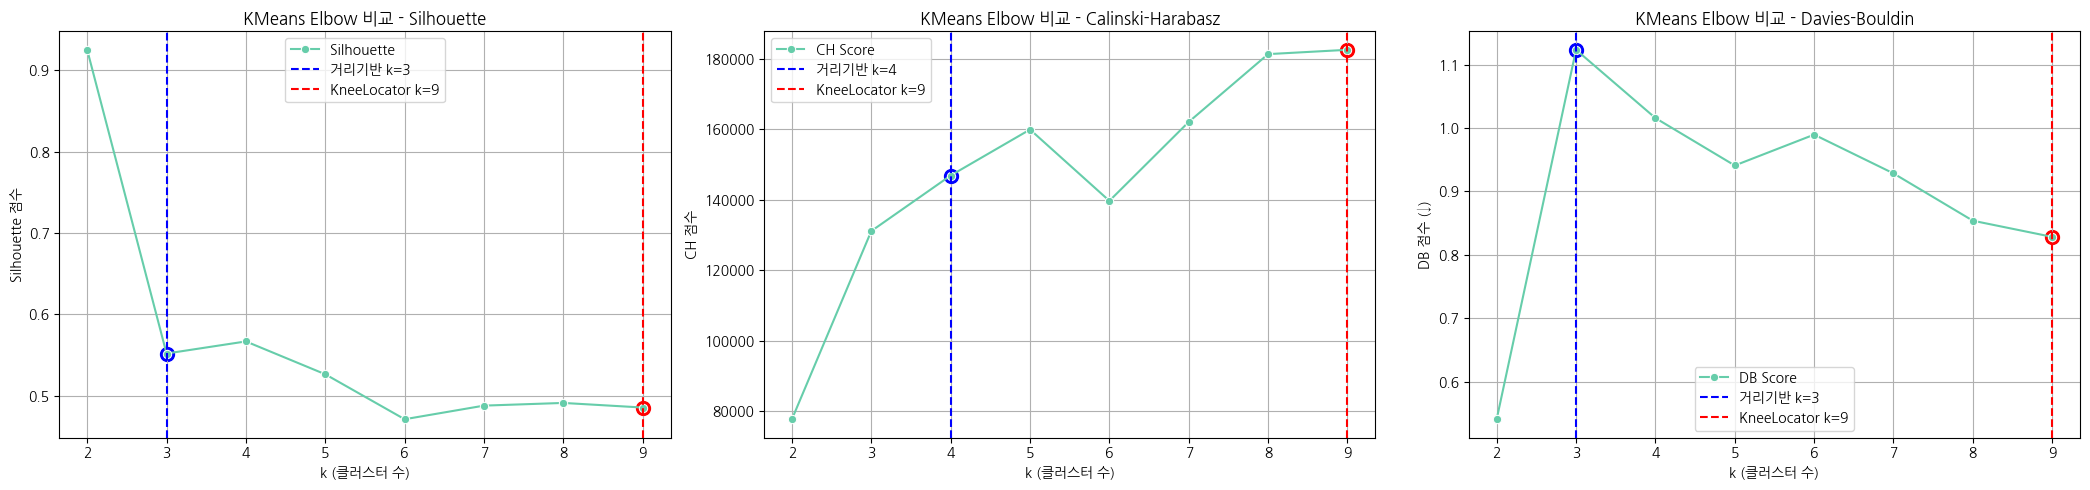

In [106]:
import seaborn as sns
import numpy as np
from kneed import KneeLocator

# 거리기반 elbow 계산 함수
def find_elbow_point(df, score_col):
    x = df["k"].to_numpy()
    y = df[score_col].to_numpy()
    start = np.array([x[0], y[0]])
    end = np.array([x[-1], y[-1]])
    distances = []
    for i in range(len(x)):
        point = np.array([x[i], y[i]])
        vec_line = end - start
        vec_point = point - start
        proj_len = np.dot(vec_line, vec_point) / np.linalg.norm(vec_line)
        proj_point = start + proj_len * vec_line / np.linalg.norm(vec_line)
        dist = np.linalg.norm(point - proj_point)
        distances.append(dist)
    best_idx = int(np.argmax(distances))
    return int(x[best_idx])

# KneeLocator 방식
def find_elbow_kneedf(df, metric, direction="increasing"):
    x = df["k"].to_list()
    y = df[metric].to_list()
    curve_type = "convex" if direction == "increasing" else "concave"
    kneedle = KneeLocator(x, y, curve=curve_type, direction=direction)
    return kneedle.knee

# 개별 지표 처리 ------------------------------

# Silhouette
df_sil = result_kmeans[["k", "silhouette"]].copy()
elbow_kmeans_dist_sil = find_elbow_point(df_sil, "silhouette")
elbow_kmeans_knee_sil = find_elbow_kneedf(df_sil, "silhouette", direction="increasing")
score_dist_sil = df_sil[df_sil["k"] == elbow_kmeans_dist_sil]["silhouette"].values[0]
score_knee_sil = df_sil[df_sil["k"] == elbow_kmeans_knee_sil]["silhouette"].values[0]

# CH
df_ch = result_kmeans[["k", "calinski_harabasz"]].copy()
elbow_kmeans_distance_ch = find_elbow_point(df_ch, "calinski_harabasz")
elbow_kmeans_knee_ch = find_elbow_kneedf(df_ch, "calinski_harabasz", direction="increasing")
score_dist_ch = df_ch[df_ch["k"] == elbow_kmeans_distance_ch]["calinski_harabasz"].values[0]
score_knee_ch = df_ch[df_ch["k"] == elbow_kmeans_knee_ch]["calinski_harabasz"].values[0]

# DB
df_db = result_kmeans[["k", "davies_bouldin"]].copy()
elbow_kmeans_distance_db = find_elbow_point(df_db, "davies_bouldin")
elbow_kmeans_knee_db = find_elbow_kneedf(df_db, "davies_bouldin", direction="decreasing")
score_dist_db = df_db[df_db["k"] == elbow_kmeans_distance_db]["davies_bouldin"].values[0]
score_knee_db = df_db[df_db["k"] == elbow_kmeans_knee_db]["davies_bouldin"].values[0]

# 시각화 ------------------------------

fig, axes = plt.subplots(1, 3, figsize=(21, 5))

# --- Silhouette
sns.lineplot(data=df_sil, x="k", y="silhouette", ax=axes[0], color="mediumaquamarine", marker="o", label="Silhouette")
axes[0].axvline(x=elbow_kmeans_dist_sil, linestyle="--", color="blue", label=f"거리기반 k={elbow_kmeans_dist_sil}")
axes[0].scatter(elbow_kmeans_dist_sil, score_dist_sil, color="blue", s=100)
axes[0].axvline(x=elbow_kmeans_knee_sil, linestyle="--", color="red", label=f"KneeLocator k={elbow_kmeans_knee_sil}")
axes[0].scatter(elbow_kmeans_knee_sil, score_knee_sil, color="red", s=100)
axes[0].set_title("KMeans Elbow 비교 - Silhouette")
axes[0].set_xlabel("k (클러스터 수)")
axes[0].set_ylabel("Silhouette 점수")
axes[0].legend()
axes[0].grid(True)

# --- CH
sns.lineplot(data=df_ch, x="k", y="calinski_harabasz", ax=axes[1], color="mediumaquamarine", marker="o", label="CH Score")
axes[1].axvline(x=elbow_kmeans_distance_ch, linestyle="--", color="blue", label=f"거리기반 k={elbow_kmeans_distance_ch}")
axes[1].scatter(elbow_kmeans_distance_ch, score_dist_ch, color="blue", s=100)
axes[1].axvline(x=elbow_kmeans_knee_ch, linestyle="--", color="red", label=f"KneeLocator k={elbow_kmeans_knee_ch}")
axes[1].scatter(elbow_kmeans_knee_ch, score_knee_ch, color="red", s=100)
axes[1].set_title("KMeans Elbow 비교 - Calinski-Harabasz")
axes[1].set_xlabel("k (클러스터 수)")
axes[1].set_ylabel("CH 점수")
axes[1].legend()
axes[1].grid(True)

# --- DB
sns.lineplot(data=df_db, x="k", y="davies_bouldin", ax=axes[2], color="mediumaquamarine", marker="o", label="DB Score")
axes[2].axvline(x=elbow_kmeans_distance_db, linestyle="--", color="blue", label=f"거리기반 k={elbow_kmeans_distance_db}")
axes[2].scatter(elbow_kmeans_distance_db, score_dist_db, color="blue", s=100)
axes[2].axvline(x=elbow_kmeans_knee_db, linestyle="--", color="red", label=f"KneeLocator k={elbow_kmeans_knee_db}")
axes[2].scatter(elbow_kmeans_knee_db, score_knee_db, color="red", s=100)
axes[2].set_title("KMeans Elbow 비교 - Davies-Bouldin")
axes[2].set_xlabel("k (클러스터 수)")
axes[2].set_ylabel("DB 점수 (↓)")
axes[2].legend()
axes[2].grid(True)

plt.tight_layout()
plt.show()

## 군집화 라벨링
- 분석 결과 클러스터링은 9개로 진행
- 세부 특성 비교 결과 일부 그룹은 그룹간 차이가 크지 않아 4개의 유형으로 재분류 
- 이렇게 분류된 4개의 유형이 최종적 클러스터링 결과 

In [107]:
def add_clustering_label(df: pl.DataFrame, label_name: str, k: int, X):
    """KMeans 클러스터링 라벨을 df에 추가하고 소요시간 출력"""
    print(f"실행 중: {label_name} (k={k})")
    start = time.time()

    # 모델 선택 및 학습
    if label_name.startswith("KMeans"):
        # scaler = StandardScaler()
        # X = scaler.fit_transform(X)

        model = KMeans(n_clusters=k, random_state=42)
        labels = model.fit_predict(X)
    else:
        raise ValueError(f"Unknown model type in label: {label_name}")

    # Polars에서는 with_columns로 라벨 추가해야 함
    df = df.with_columns(pl.Series(label_name, labels))

    end = time.time()
    print(f"완료: {label_name} | 소요시간: {end - start:.2f}초\n")

    return df

In [108]:
k_values = {
    "KMeans_DB_거리기반": elbow_kmeans_knee_db
}

In [109]:
for label, k in k_values.items():
    df = clustering_origin.clone()
    df = df.drop(['고객ID', '연령대'])
    df = add_clustering_label(df, label, k, X)

실행 중: KMeans_DB_거리기반 (k=9)
완료: KMeans_DB_거리기반 | 소요시간: 0.94초



In [110]:
# 중분류로 라벨링 

df = df.to_pandas()
df['중분류'] = df['KMeans_DB_거리기반'].apply(lambda x: 'A' if x == 0 else 'B' if x in [1,5] else 'C' if x in [4,6,7] else 'D')

## 클러스터링 Scaler 비교
- Standard Scaler : 평균과 표준편차를 사용한 스케일러로, 데이터를 평균 0, 표준편차 1의 데이터가 되도록 스케일링한다. 평균을 쓰기 때문에 이상치의 영향을 크게 받는다는 단점이 존재한다.
- Robust Scaler : Standard Scaler와는 달리 평균과 표준편차 대신 Median과 IQR을 사용한다. 평균 관련 통계량을 사용하지 않으므로 이상치에 민감하지 않으나, 이상치가 매우 많을 경우 역으로 데이터의 분포가 이상해지는 단점이 존재한다.
- 결론적으로 Standard Scaler를 사용해 스케일링 후 K-means를 진행하기로 하였다.

In [111]:
import pandas as pd

# 데이터에 필요없는 열 제거 (클러스터용이 아닌 데이터 모두 삭제 )
data_tmp = df_tmp.to_pandas().drop(columns=['고객ID', '거래기간(개월)', '평균_총점수', '최대_보유상품종류', '연령대',
                                 '최대_고객등급', 'KMeans_DB_KneeLocato_2030', '중분류'])

In [112]:
# Robust 스케일링 후 클러스터링 함수

def kmeans_clustering_2(data, n_clusters=9):
    """
    K-means 클러스터링 수행 - RobustScaler 적용 및 클러스터별 특징 시각화
    """
    
    # 스케일러 적용
    scaler = RobustScaler()
    data_scaled = scaler.fit_transform(data)
    
    # K-means 클러스터링 수행
    kmeans = KMeans(n_clusters=n_clusters)
    clusters = kmeans.fit_predict(data_scaled)

    return clusters


In [113]:
# RobustScaler 적용 후 클러스터링 
tmp = kmeans_clustering_2(data_tmp)

In [114]:
# 중분류로 분류화 - 자체기준 
clusters_tmp = pd.Series(tmp).apply(lambda x: 'A' if x == 0 else 'B' if x in [1,5] else 'C' if x in [4,6,7] else 'D')

<Axes: ylabel='count'>

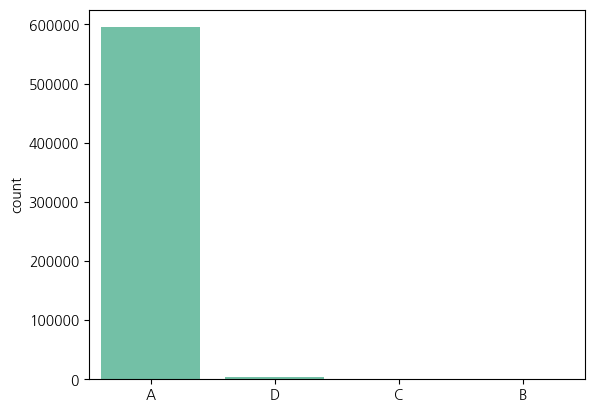

In [115]:
sns.barplot(clusters_tmp.value_counts(), color='mediumaquamarine')

<Axes: xlabel='중분류', ylabel='count'>

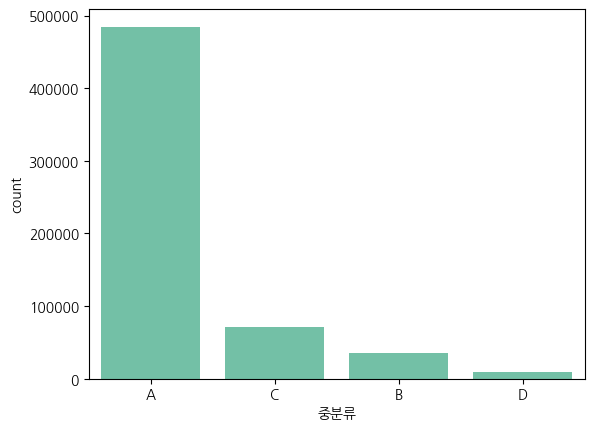

In [116]:
# dat_1의 '중분류'는 이미 Standard Scaler를 적용해 클러스터링 한 결과이다. 
sns.barplot(df_tmp['중분류'].to_pandas().value_counts(), color='mediumaquamarine')

# 클러스터링 기반 EDA
- Standard Scaler와 Robust Scaler 적용하여 군집화 후 비교
    - 결과: Standard Scaler의 군집화가 더 각 군집의 특성이 뚜렷하게 보이며, 각 군집의 빈도수도 높기에 Standard Scaler를 적용함
- 그룹 B는 타 그룹과 이질적이게 대출의 비중이 아주 큼, 유형 B의 대출 금액 시각화
- 각 그룹 별 금융 자산 규모 정리
- 유형별 금융 자산 전체 합계 및 1인 평균 자산 시각화

In [91]:
type(df_tmp)

polars.dataframe.frame.DataFrame

In [92]:
import pandas as pd

dat_1 = df_tmp.to_pandas().copy() #메인 데이터 데이터프레임 화 

## 각 유형 그룹 별 금융 자산 비교
- 각 금융 자산별로 시각화 자료를 그려 해당 금융 자산 내에서의 특정 그룹의 이용액, 분포 등을 관측한다. 

In [93]:
# 사용 팔레트 - 각 그룹별로 Identify가 더 쉽도록 유형 별로 다른 색상 부여
sns.color_palette('Set2')

[(0.4, 0.7607843137254902, 0.6470588235294118),
 (0.9882352941176471, 0.5529411764705883, 0.3843137254901961),
 (0.5529411764705883, 0.6274509803921569, 0.796078431372549),
 (0.9058823529411765, 0.5411764705882353, 0.7647058823529411),
 (0.6509803921568628, 0.8470588235294118, 0.32941176470588235),
 (1.0, 0.8509803921568627, 0.1843137254901961),
 (0.8980392156862745, 0.7686274509803922, 0.5803921568627451),
 (0.7019607843137254, 0.7019607843137254, 0.7019607843137254)]

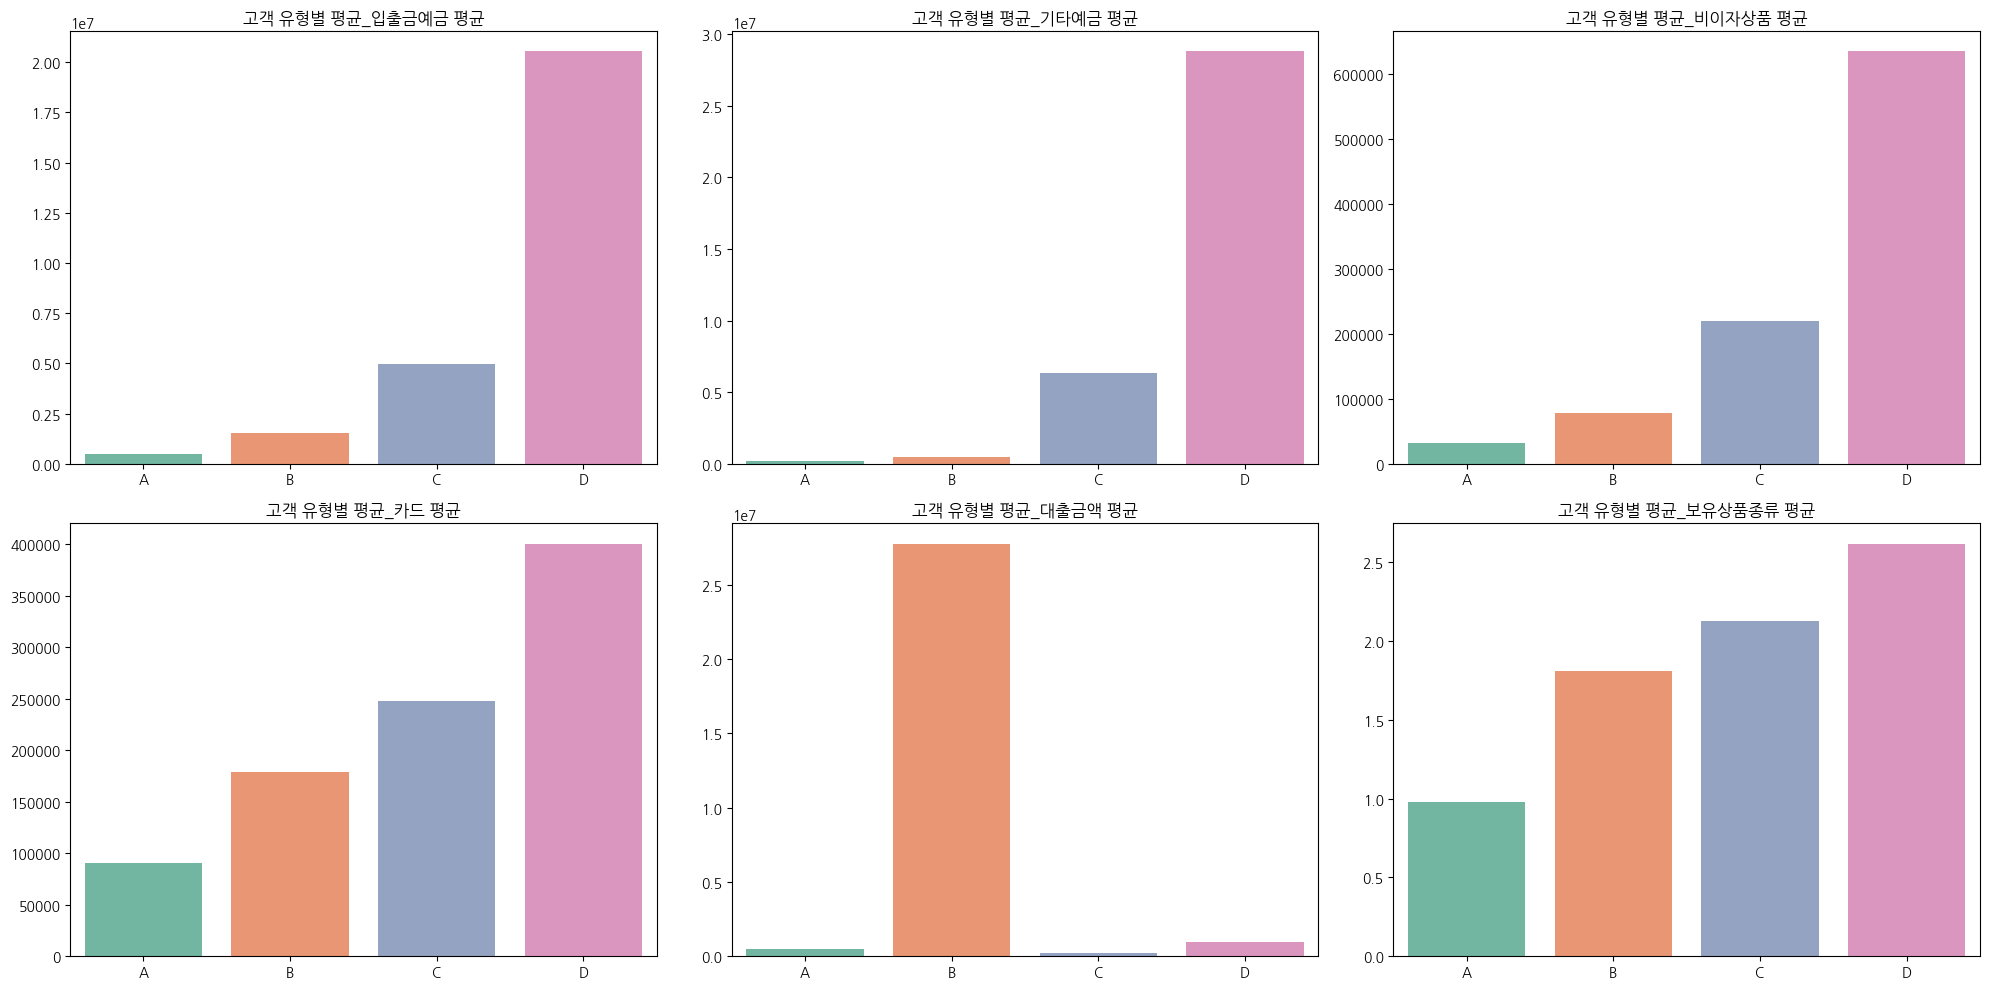

In [117]:
# 유형 별 금융자산 규모 비교 시각화 

# 금융자산 열 추출 
financial_columns = ['평균_입출금예금', '평균_기타예금', '평균_비이자상품', '평균_카드', '평균_대출금액', '평균_보유상품종류']

fig, axs = plt.subplots(2, 3, figsize=(20, 10))

for i, column in enumerate(financial_columns):
    row = i // 3
    col = i % 3
    sns.barplot(y=column, x='중분류', data=dat_1, ci=None, order=['A', 'B', 'C', 'D'], palette='Set2', ax=axs[row, col]) # 자동으로 평균으로 계산하는듯
    axs[row, col].set_title(f'고객 유형별 {column} 평균')
    axs[row, col].set_ylabel('')
    axs[row, col].set_xlabel('') #.set_xlabel('고객 유형')

plt.tight_layout()
plt.show()

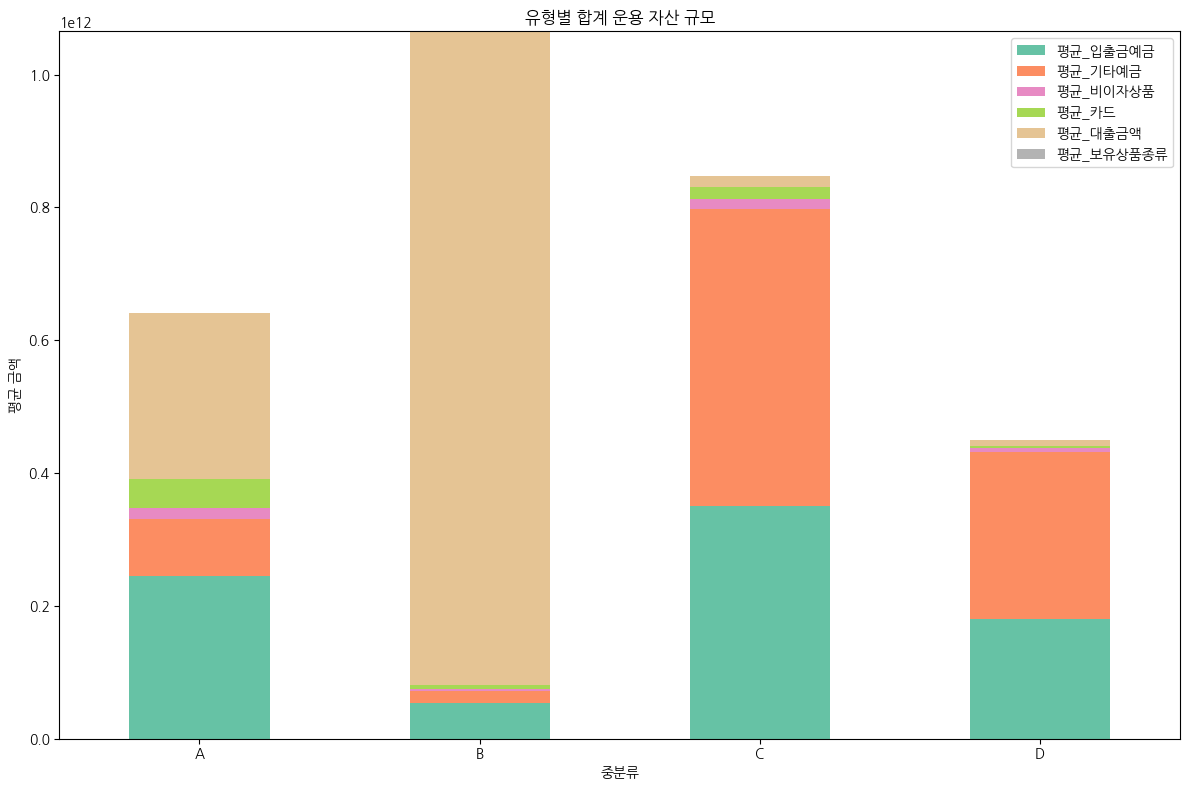

In [118]:
# 유형 별 금융자산 총 합 비교 시각화
# 총 자산 비율 내 포트폴리오 구성을 알기 위해 Stacked Bar 사용 

# '중분류' 열의 고유 값 및 원하는 순서 정의
categories = ['A', 'B', 'C', 'D']

# 각 '중분류'별 금융 상품 평균 금액 계산 및 인덱스 재정렬
grouped_data = dat_1.groupby('중분류')[financial_columns].sum().reindex(categories)

# stacked bar 그래프 생성
grouped_data.plot(kind='bar', stacked=True, figsize=(12, 8), cmap='Set2')

plt.title('유형별 합계 운용 자산 규모')
plt.xlabel('중분류')
plt.ylabel('평균 금액')
plt.xticks(rotation=0)  # x축 레이블 회전 제거
plt.tight_layout()
plt.show()

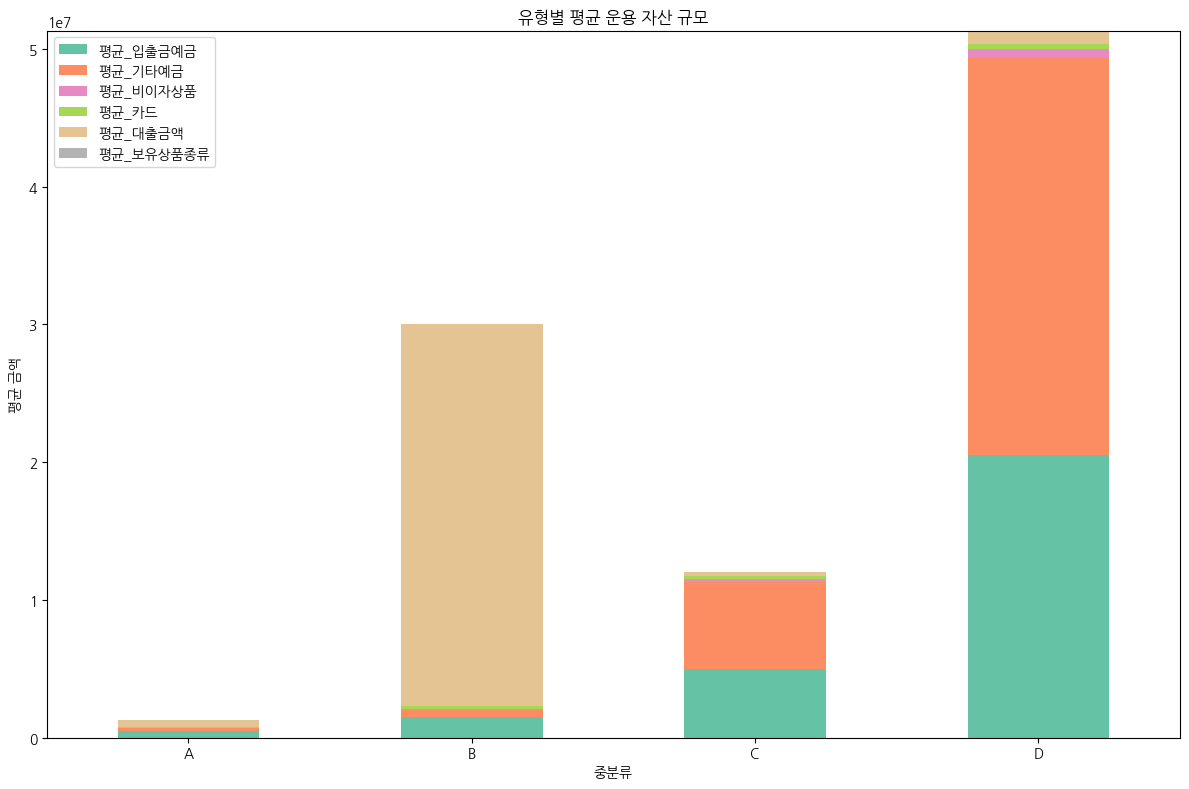

In [119]:
# 유형 별 금융자산 1인 평균 비교 시각화
# 총 자산 비율 내 포트폴리오 구성을 알기 위해 Stacked Bar 사용 

# 각 '중분류'별 금융 상품 평균 금액 계산 및 인덱스 재정렬
grouped_data_2 = dat_1.groupby('중분류')[financial_columns].mean().reindex(categories)

# stacked bar 그래프 생성
grouped_data_2.plot(kind='bar', stacked=True, figsize=(12, 8), cmap='Set2')

plt.title('유형별 평균 운용 자산 규모')
plt.xlabel('중분류')
plt.ylabel('평균 금액')
plt.xticks(rotation=0)  # x축 레이블 회전 제거
plt.tight_layout()
plt.show()

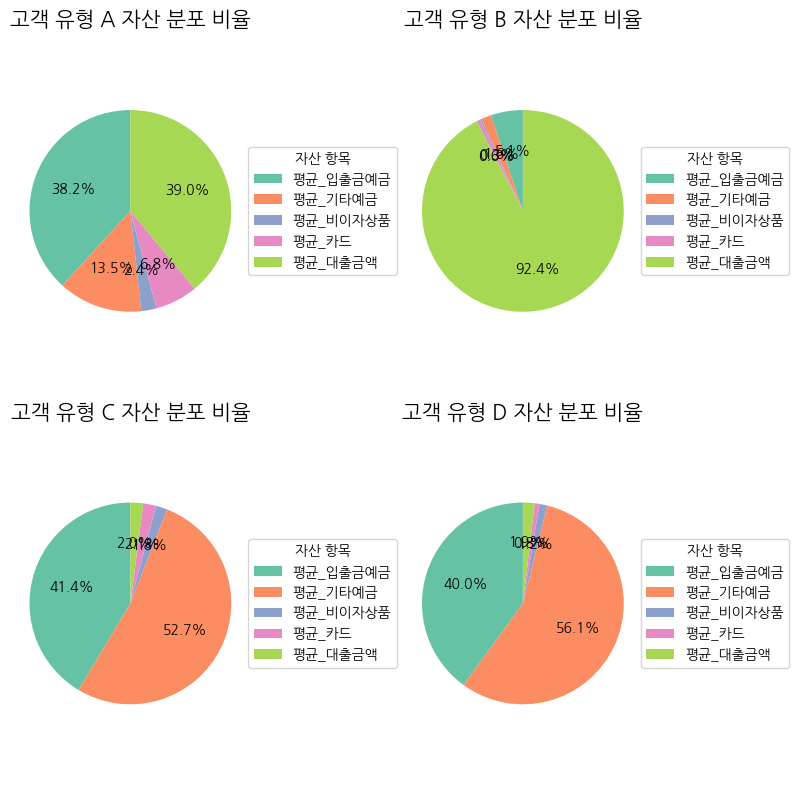

In [120]:
# 자산 관련 열 선택
asset_columns = ['평균_입출금예금', '평균_기타예금', '평균_비이자상품', '평균_카드', '평균_대출금액']

# 각 자산의 총합 계산
asset_totals = dat_1.groupby('중분류')[asset_columns].mean()

# 각 행을 하나의 파이 차트로 그리시오.
fig, axs = plt.subplots(2, 2, figsize=(8, 8))
for i, (index, row) in enumerate(asset_totals.iterrows()):
    row_idx = i // 2
    col_idx = i % 2
    wedges, texts, autotexts = axs[row_idx, col_idx].pie(row, autopct='%1.1f%%', startangle=90, colors=color_palette)
    axs[row_idx, col_idx].set_title(f'고객 유형 {index} 자산 분포 비율', fontsize = 15)
    axs[row_idx, col_idx].axis('equal')
    axs[row_idx, col_idx].legend(wedges, asset_columns, title='자산 항목', loc='center left', bbox_to_anchor=(1, 0.5))  # 범례 추가
plt.subplots_adjust(hspace=0.000001)
plt.tight_layout()
plt.show()

## 레이더 차트 
- 각 군집이 어느 금융자산에 특화되었는지 확인 

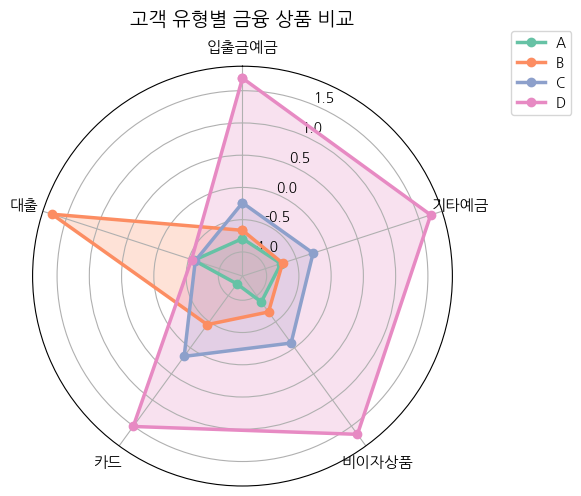

In [121]:
# 필요한 컬럼만 선택
columns = [
    "중분류", 
    "평균_입출금예금", 
    "평균_기타예금", 
    "평균_비이자상품", 
    "평균_카드", 
    "평균_대출금액"
]

df_selected = df_tmp.select(columns)

# 중분류별 평균값으로 집계 (polars → pandas 변환)
df_grouped = (
    df_selected
    .group_by("중분류")
    .mean()
    .to_pandas()
)

# 4. 정규화 (MinMaxScaler)
value_cols = [
    "평균_입출금예금",
    "평균_기타예금",
    "평균_비이자상품",
    "평균_카드",
    "평균_대출금액"
]

scaler = StandardScaler()
df_grouped_scaled = df_grouped.copy()
df_grouped_scaled[value_cols] = scaler.fit_transform(df_grouped[value_cols])

short_labels = ["입출금예금", "기타예금", "비이자상품", "카드", "대출"]

# Set2에서 4가지 색상 가져오기
palette = sns.color_palette("Set2", 4)

# 중분류를 A → D 순서대로 색상 고정 매핑
ordered_labels = ["A", "B", "C", "D"]
color_map = dict(zip(ordered_labels, palette))

def make_radar_chart(data, labels, title):
    num_vars = len(labels)
    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
    angles += angles[:1]

    fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))

    for 중분류 in ordered_labels:  # A → D 순서대로 그리기
        row = data[data["중분류"] == 중분류].iloc[0]
        values = row[value_cols].tolist()
        values += values[:1]
        color = color_map[중분류]

        # ax.plot(angles, values, label=중분류, color=color)
        # ax.fill(angles, values, alpha=0.15, color=color)
        ax.plot(angles, values, label=중분류, color=color, linewidth=2.5, marker="o")
        ax.fill(angles, values, alpha=0.25, color=color)


    ax.set_theta_offset(np.pi / 2)
    ax.set_theta_direction(-1)
    ax.set_thetagrids(np.degrees(angles[:-1]), labels, fontsize=11)
    ax.set_title(title, size=14, pad=30)
    ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
    plt.tight_layout()
    #plt.savefig('radar_chart.png')
    plt.show()


# 실행
make_radar_chart(df_grouped_scaled, short_labels, "고객 유형별 금융 상품 비교")

### 그룹 B 분석 - 대출이 많은 비중
- 그룹 B가 대출이 가장 많으며, 활발한 모습을 보인다. 이들의 특징이 무엇일까?
- 그룹 B는 전체적으로 대출 '만' 하러 iM뱅크를 사용하는 것으로 보인다. 
    - 다른 금융상품과의 유사성 또는 뚜렸한 선형적 관계가 관측되지 않음 (pairplot 참조)
- 유형 B 및 타 그룹간 전체 대출 규모 및 1인당 평균 대출 규모 비교 

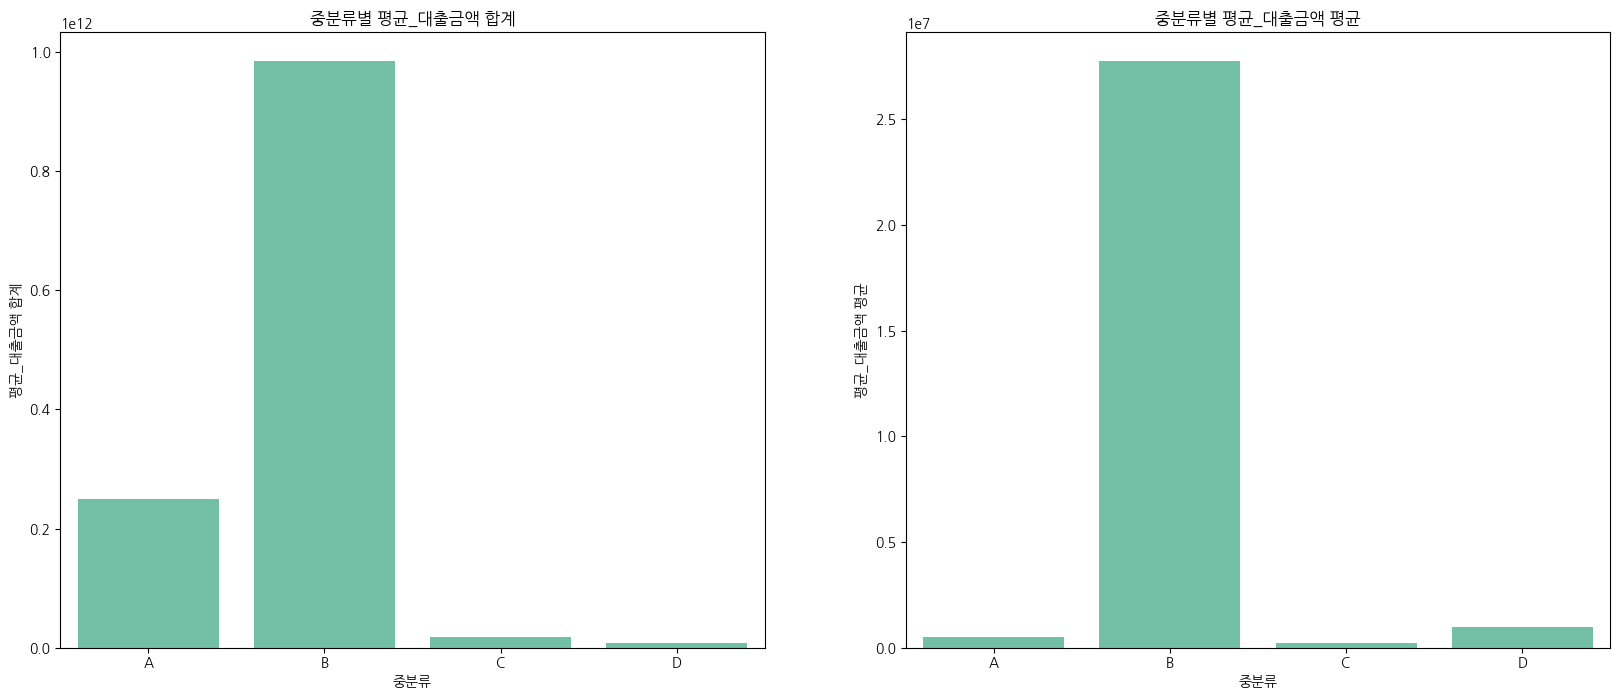

In [122]:
# 유형 B 시각화

tmp = dat_1.groupby('중분류').agg({
    '평균_대출금액': ['sum', 'mean'] #그룹별 대출금액의 합계, 평균 생성 
}).reset_index()

fig, axs = plt.subplots(1, 2, figsize=(20, 8))
sns.barplot(x='중분류', y=('평균_대출금액', 'sum'), data=tmp, color=color, ax=axs[0])
sns.barplot(x='중분류', y=('평균_대출금액', 'mean'), data=tmp, color=color, ax=axs[1])
axs[0].set_title('중분류별 평균_대출금액 합계')
axs[1].set_title('중분류별 평균_대출금액 평균')
plt.xlabel('중분류')
axs[0].set_ylabel('평균_대출금액 합계')
axs[1].set_ylabel('평균_대출금액 평균')
plt.show()

In [123]:
# 각 그룹간으로 나눠서 관측 

As = dat_1[dat_1['중분류'] == 'A'][asset_columns]
bs = dat_1[dat_1['중분류'] == 'B'][asset_columns] # B그룹만 집중적으로 관측 
cs = dat_1[dat_1['중분류'] == 'C'][asset_columns]
ds = dat_1[dat_1['중분류'] == 'D'][asset_columns]

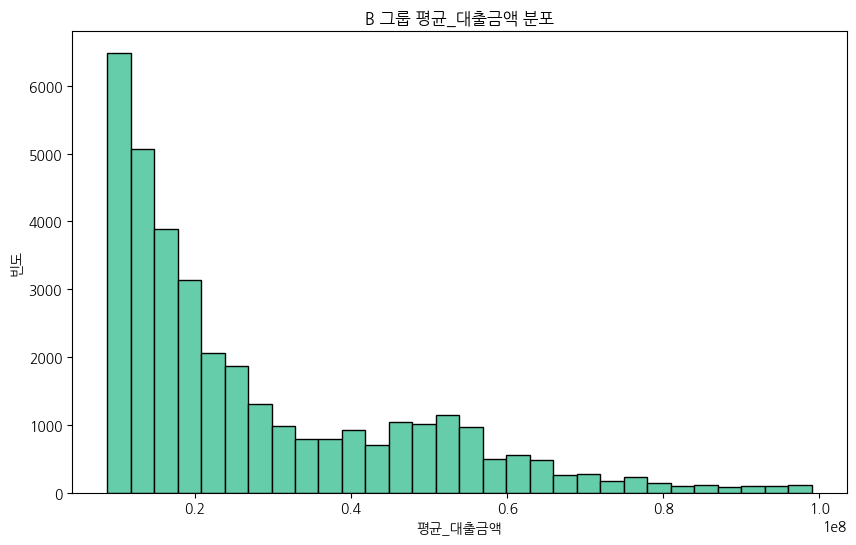

In [124]:
plt.figure(figsize=(10, 6))
plt.hist(bs['평균_대출금액'], bins=30, edgecolor='black', color=color)
plt.title('B 그룹 평균_대출금액 분포')
plt.xlabel('평균_대출금액')
plt.ylabel('빈도')
plt.show()

# PCA 활용 K-means 클러스터링 시각화
- PCA를 통해 주성분을 2개, 3개로 설정하여 2차원, 3차원 시각화를 생성

In [125]:
# 데이터 불러오기

data_final = pd.read_csv('data/상품집계_고객집계.csv')
data_final.shape

(599499, 14)

In [126]:
# 분석용 금융데이터 조정 
from sklearn.decomposition import PCA

pca_data = data_final.drop(columns=['고객ID','거래기간(개월)' ,'평균_총점수', '최대_보유상품종류', '최대_고객등급','연령대' ,'KMeans_DB_KneeLocato_2030', '중분류'])

In [127]:
# PCA를 활용하여 2차원으로 차원 축소 후 시각화 

def visualize_pca_clustering(pca_data, n_clusters=4):
    # 표준화 (PCA 및 KMeans 성능 향상)
    scaler = StandardScaler()
    pca_data_scaled = scaler.fit_transform(pca_data)

    # K-Means 클러스터링
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    clusters = kmeans.fit_predict(pca_data_scaled)

    # PCA 변환 (2차원 축소)
    pca = PCA(n_components=2)
    reduced_2d = pca.fit_transform(pca_data_scaled)

    # 시각화
    plt.figure(figsize=(15, 7))

    # Seaborn의 Set2 색상 가져오기
    palette = sns.color_palette("Set2", n_clusters)
    cluster_colors = [palette[i] for i in clusters]

    for i in range(n_clusters):
        plt.scatter(reduced_2d[clusters == i, 0], reduced_2d[clusters == i, 1], 
                    label=f'Cluster {i}', alpha=0.7, s=50, color=palette[i])
    '''
    # 클러스터 중심점 (Centroids) 시각화
    centroids = pca.transform(kmeans.cluster_centers_)
    plt.scatter(centroids[:, 0], centroids[:, 1], c='black', marker='X', s=300, edgecolors='white', label='Centroids')
    '''
    # 그래프 설정
    plt.title("PCA 기반 클러스터링 시각화", fontsize=14)
    plt.xlabel("주성분 1 (PCA1)", fontsize=12)
    plt.ylabel("주성분 2 (PCA2)", fontsize=12)
    plt.legend(loc='best', fontsize=10)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.show()

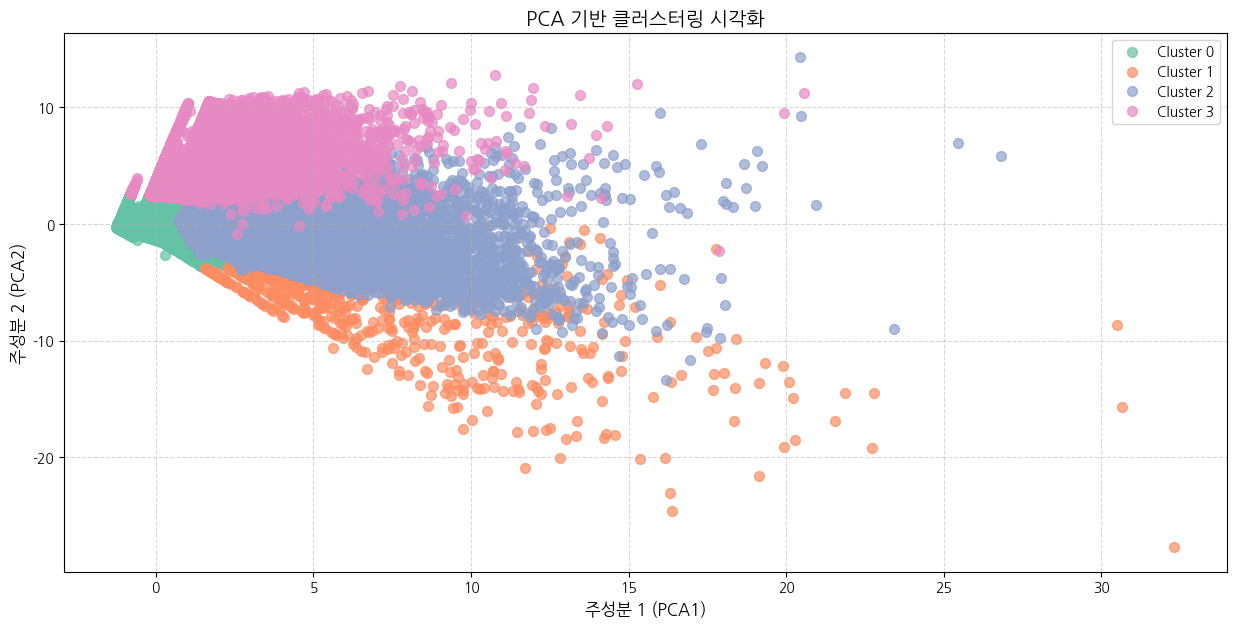

In [128]:
# 실행 코드
visualize_pca_clustering(pca_data)

In [129]:
# 3차원 PCA 이후 클러스터링 3D시각화

def visualize_3d_pca(pca_data, n_clusters=4):
    # 표준화 (PCA 및 KMeans 성능 향상)
    scaler = StandardScaler()
    pca_data_scaled = scaler.fit_transform(pca_data)

    # K-Means 클러스터링
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    clusters = kmeans.fit_predict(pca_data_scaled)

    # PCA 변환 (3차원 축소)
    pca = PCA(n_components=3)
    reduced_3d = pca.fit_transform(pca_data_scaled)

    # Seaborn의 Set2 색상 가져오기
    palette = sns.color_palette("Set2", n_clusters)
    cluster_colors = [palette[i] for i in clusters]

    # 3D 시각화
    fig = plt.figure(figsize=(20, 7))
    ax = fig.add_subplot(111, projection='3d')

    # 클러스터 별 산점도
    for i in range(n_clusters):
        ax.scatter(reduced_3d[clusters == i, 0], reduced_3d[clusters == i, 1], reduced_3d[clusters == i, 2], 
                   label=f'Cluster {i}', alpha=0.7, s=50, color=palette[i])

    # 그래프 설정
    ax.set_box_aspect((15, 7, 4))  # (x축 비율, y축 비율, z축 비율), 3D시각화 조절의 핵심 코드

    # 각 축 라벨 비활성화 
    ax.set_title("3D PCA 기반 클러스터링 시각화", fontsize=14)
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.set_zlabel("")
    ax.legend(loc='best', fontsize=10)

    # 3D 회전 각도 설정 (조절 가능)
    ax.view_init(elev=20, azim=80)

    plt.show()

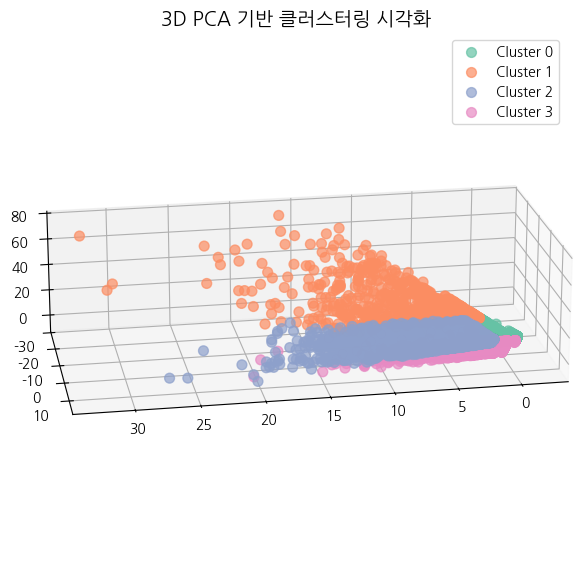

In [130]:
visualize_3d_pca(pca_data)